In [1]:
import pandas as pd
import os,sys
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import urllib
import sqlite3
import json
import time
import ssl
import pandas as pd
import numpy as np
import re as re
from matplotlib import *
from pylab import *
rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams.update({'font.size': 12})
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'semibold'

In [2]:
train=pd.read_csv('train_mrt.csv.gz', header=0)
train=train.sort_values(by='month').reset_index()
target='resale_price'
# SQL name as found in SQLite database
train['sql_name']=train['street_name']+' '+train['block']+'  SINGAPORE'

In [3]:
#set up missing values with mean~0.8km
x=train[train['dist_nearestMRT'].isnull()]['dist_nearestMRT'].index
train.set_value(x,'dist_nearestMRT',0.8)
train.set_value(x,'nearestMRT','REDHILL MRT')

,level_0,index,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,sql_name,lat,lng,nearestMRT,dist_nearestMRT
0,0,679,1990-01,GEYLANG,3 ROOM,40,CIRCUIT RD,01 TO 03,57,STANDARD,1971,23400,CIRCUIT RD 40 SINGAPORE,1.327679,103.886079,MACPHERSON MRT,0.435332
1,1019,609,1990-01,CLEMENTI,4 ROOM,113,CLEMENTI ST 13,04 TO 06,104,MODEL A,1984,82000,CLEMENTI ST 13 113 SINGAPORE,1.323667,103.770164,CLEMENTI MRT,1.115466
2,1018,610,1990-01,CLEMENTI,4 ROOM,205,CLEMENTI AVE 6,04 TO 06,92,NEW GENERATION,1984,94000,CLEMENTI AVE 6 205 SINGAPORE,1.321060,103.762407,CLEMENTI MRT,0.704132
3,1017,611,1990-01,CLEMENTI,5 ROOM,414,C'WEALTH AVE WEST,10 TO 12,125,IMPROVED,1978,152000,C'WEALTH AVE WEST 414 SINGAPORE,1.311585,103.771559,DOVER MRT,0.789174
4,1016,596,1990-01,CLEMENTI,3 ROOM,710,CLEMENTI WEST ST 2,01 TO 03,68,NEW GENERATION,1984,41500,CLEMENTI WEST ST 2 710 SINGAPORE,1.306069,103.761342,CLEMENTI MRT,1.084725
5,1015,594,1990-01,CLEMENTI,3 ROOM,728,CLEMENTI WEST ST 2,01 TO 03,68,NEW GENERATION,1980,47000,CLEMENTI WEST ST 2 728 SINGAPORE,1.305366,103.763777,CLEMENTI MRT,1.098612
6,1014,577,1990-01,CLEMENTI,3 ROOM,520,WEST COAST RD,10 TO 12,67,NEW GENERATION,1986,52500,WEST COAST RD 520 SINGAPORE,1.307111,103.759778,CLEMENTI MRT,1.057621
7,1013,593,1990-01,CLEMENTI,3 ROOM,731,CLEMENTI WEST ST 2,07 TO 09,68,NEW GENERATION,1980,47000,CLEMENTI WEST ST 2 731 SINGAPORE,1.304212,103.762771,CLEMENTI MRT,1.241642
8,1012,578,1990-01,CLEMENTI,3 ROOM,602,CLEMENTI WEST ST 1,10 TO 12,67,NEW GENERATION,1979,52500,CLEMENTI WEST ST 1 602 SINGAPORE,1.305120,103.766212,CLEMENTI MRT,1.131190
9,1011,579,1990-01,CLEMENTI,3 ROOM,607,CLEMENTI WEST ST 1,04 TO 06,67,NEW GENERATION,1979,43000,CLEMENTI WEST ST 1 607 SINGAPORE,1.304253,103.767733,CLEMENTI MRT,1.259742


In [4]:
# mrt station built date file
a=pd.read_csv('mrt_date.csv')
print a.head() # i know the formatting has problem, but watever

  Alpha-Numeric Code    Station name  Opening  Construction names   \
0         NS1  EW24      Jurong East      裕廊东      ஜூரோங் கிழக்கு    
1               NS2      Bukit Batok     武吉巴督   புக்கிட் பாத்தோக்    
2               NS3     Bukit Gombak     武吉甘柏   புக்கிட் கோம்பாக்    
3          NS4  BP1    Choa Chu Kang      蔡厝港        சுவா சூ காங்    
4               NS5          Yew Tee       油池              இயூ டீ    

        Abbreviation            Unnamed: 5 Unnamed: 6  
0     10 March 1990           Jurong East         JUR  
1     10 March 1990     Bukit Batok South         BBT  
2     10 March 1990     Bukit Batok North         BGB  
3     10 March 1990         Choa Chu Kang         CCK  
4  10 February 1996   Choa Chu Kang North         YWT  


In [5]:
stn_names=map(lambda x : str(x) , a['Station name ']) 
stn_times=map(lambda x : str(x).split() , a['Abbreviation']) # Abbreviation columns gives dates of construction
dictt_temp = {'February': 2, 'October': 10, 'March': 3, 'May': 5,
              'December': 12, 'June': 6, 'April': 4, 'January': 1,
              'November': 11, 'July': 7}
dict_startMRT = {}
for i in range(len(stn_names)):
    if len(stn_times[i]) >= 3:
        stn_times[i][1]=dictt_temp[stn_times[i][1]]
        dict_startMRT[stn_names[i].upper()+'MRT']= \
        round(int(stn_times[i][2])+1.0*stn_times[i][1]/12,2)  #get MRT built date as float
# get mrt built date from nearest mrt
train['MRTbuilt'] = train['nearestMRT'].map(dict_startMRT)

In [6]:
target='resale_price'
predictors=[x for x in  list(train.keys()) if x!=target]
dictt={}
for i in predictors :
    dictt[i]=list(train[i].unique())

In [7]:
'''
Next few lines change string catagorical values to integers, 
since strings are hard to handle
'''
### Changing month to float
dictt_month = {}
for i in dictt['month']:
    dictt_month[i]=round(int(i[0:4])+float(i[-2:])*1.0/12,1)
train['month']=train['month'].map(dictt_month).astype(np.float32)
train['Time_sinceMRTbuilt']=train['month']-train['MRTbuilt']

In [8]:
#### nearest mrt_station to integer
dictt_nearestMRT={}
counter=0
for i in dictt['nearestMRT']:
    dictt_nearestMRT[i]=counter
    counter +=1
train['nearestMRT']=train['nearestMRT'].map(dictt_nearestMRT)

In [9]:
### Changing flat_type
dictt_flattype={}
dictt_flattype={'3 ROOM': 3, '4 ROOM': 4, '1 ROOM': 1,
                'MULTI GENERATION': 7, 'MULTI-GENERATION':
                8, 'EXECUTIVE': 6,
                '5 ROOM': 5, '2 ROOM': 2}
train['flat_type']=train['flat_type'].map(dictt_flattype).astype(np.int16)

In [10]:
# convert story range from string to integer
train['storey_range'].head()

0    01 TO 03
1    04 TO 06
2    04 TO 06
3    10 TO 12
4    01 TO 03
Name: storey_range, dtype: object

In [11]:
train['storey_range']=train['storey_range'].map(lambda x:0.5*int(x[0:2])+0.5*int(x[-2:]))
train['storey_range'].head()

0     2
1     5
2     5
3    11
4     2
Name: storey_range, dtype: float64

In [12]:
# convert street names to integers
dictt_street_name={}
counter=0
for i in sorted(train.street_name.unique()):
    dictt_street_name[i]=counter
    counter += 1
train['street_name']=train['street_name'].map(dictt_street_name)

In [13]:
# convert block names to integers, blocks might be 123A , which will be conveted to 123
dictt_block={}
import string
for i in sorted(train.block.unique()):
    dictt_block[i]=int(i.translate(None,string.letters)) #keep digits only 
train['block']=train['block'].map(dictt_block)

In [14]:
'''
This does two things
1. adds monthly mean of prices as an additional explanatory variable. 
This models in external factors like economic growth, inflation and others 
into the model implicitly, and this number can be estimated with the help 
of a professional real estate agent for future modelling

2. adds normalized target variable compared to montly mean. To model 
the relative prices to other houses. This is a rough measure, can use 
stratified mean of different types of flats instaed
'''
### Sorting towns by prices , then giving them number
dictt_town = {}
for i in sorted(train['month'].unique()):
    dictt_month[i]= np.median(train[train['month']==i][target]) #median instead of mean
train['month_mean']=train['month'].map(dictt_month).astype(np.int64) #adds monthly mean resale price as a feature
train['nor'+target]=1.0*train[target]/train['month_mean']

In [15]:
''' 
getting the price per square meter, normalized by mean of houses sold that month. 
Gives a guage of how expensive the house is relative to other places in singapore
per sqm .
'''
train['price_sqm_unNorm']=train[target]/(train['month_mean']*train['floor_area_sqm']) #normalized by monthly mean
train['price_sqm']=0
for x in train.month.unique(): #normalized to using median of month as base
    idx = train[train['month']==x].index
    temp=train['price_sqm_unNorm'][train['month']==x]/np.median(train[train['month']==x]['price_sqm_unNorm'])
    temp=train.set_value(idx,'price_sqm',temp)  #price per sqm here is normalized to have a median of 1
train['lease_length']=train.month - train.lease_commence_date

In [16]:
# maps town to integer
x=[]
for i in list(train['town'].unique()):
    x+= [[ i,np.mean(train[train['town']==i]['nor'+target])],]
counter=0
for i in sorted(x,key=lambda x:x[0]):
    dictt_town[i[0]]=counter
    counter+=1
train['town']=train['town'].map(dictt_town).astype(np.int32)
predictors+=['month_mean', 'nor'+target]

In [17]:
for i in sorted(train['town'].unique()):
    print [town for town in dictt_town if dictt_town[town]==i], np.mean(train[train['town']==i]['price_sqm'])

['ANG MO KIO'] 1.02927906925
['BEDOK'] 1.03563430089
['BISHAN'] 1.30698771489
['BUKIT BATOK'] 0.974601276451
['BUKIT MERAH'] 1.20348747106
['BUKIT PANJANG'] 0.924237252676
['BUKIT TIMAH'] 1.31239841751
['CENTRAL AREA'] 1.28695575402
['CHOA CHU KANG'] 0.962280968279
['CLEMENTI'] 1.08980396079
['GEYLANG'] 1.05331580409
['HOUGANG'] 1.02007032075
['JURONG EAST'] 0.973671735779
['JURONG WEST'] 0.905692079313
['KALLANG/WHAMPOA'] 1.13514477669
['LIM CHU KANG'] 0.528550628496
['MARINE PARADE'] 1.35092936392
['PASIR RIS'] 1.08122817434
['PUNGGOL'] 1.06463585116
['QUEENSTOWN'] 1.10755189806
['SEMBAWANG'] 0.959462624377
['SENGKANG'] 1.03156979899
['SERANGOON'] 1.10235597148
['TAMPINES'] 1.08591966796
['TOA PAYOH'] 1.11369622781
['WOODLANDS'] 0.889739537079
['YISHUN'] 0.94542863829


In [18]:
'''
convert flat model to integer
There are so many catagories, so i have no idea what are the differences. 
Many are probably obselete
'''
dictt_flat_model={}
counter=0

xxx=[]
for i in list(train['flat_model'].unique()):
    xxx+= [[ i,np.mean(train[train['flat_model']==i]['nor'+target])],]
counter=0
for i in sorted(xxx,key=lambda x:x[1]):
    dictt_flat_model[i[0]]=counter
    counter+=1
train['flat_model']=train['flat_model'].map(dictt_flat_model)
dictt_flat_model

{'2-ROOM': 0,
 '2-room': 1,
 'ADJOINED FLAT': 5,
 'APARTMENT': 26,
 'Adjoined flat': 15,
 'Apartment': 18,
 'DBSS': 20,
 'IMPROVED': 13,
 'IMPROVED-MAISONETTE': 25,
 'Improved': 11,
 'Improved-Maisonette': 16,
 'MAISONETTE': 30,
 'MODEL A': 12,
 'MODEL A-MAISONETTE': 27,
 'MULTI GENERATION': 32,
 'Maisonette': 19,
 'Model A': 10,
 'Model A-Maisonette': 17,
 'Model A2': 8,
 'Multi Generation': 21,
 'NEW GENERATION': 4,
 'New Generation': 3,
 'PREMIUM APARTMENT': 33,
 'Premium Apartment': 14,
 'Premium Apartment Loft': 24,
 'Premium Maisonette': 29,
 'SIMPLIFIED': 6,
 'STANDARD': 9,
 'Simplified': 2,
 'Standard': 7,
 'TERRACE': 22,
 'Terrace': 23,
 'Type S1': 28,
 'Type S2': 31}

In [19]:
'''
index 
Varaibles changed to float
month 
lease_commence_date 

Changed to interger
town 
flat_type 
block 
street_name
storey_range 
floor_area_sqm 
flat_model 

New features
sql_name
lat
lng
nearestMRT
dist_nearestMRT
MRTbuilt
Time_sinceMRTbuilt
month_mean # average resale price for particular month
norresale_price # normalized resale price for particular month
price_sqm_unNorm #price per sqm for, unnormalized ranges  ~ 0.02
price_sqm # normalized to have an average of 1 (divde by median)
lease_length

'''
predictors=[x for x in  list(train.keys()) if x!=target]
print predictors


['level_0', 'index', 'month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'sql_name', 'lat', 'lng', 'nearestMRT', 'dist_nearestMRT', 'MRTbuilt', 'Time_sinceMRTbuilt', 'month_mean', 'norresale_price', 'price_sqm_unNorm', 'price_sqm', 'lease_length']


In [20]:
from matplotlib import *
from matplotlib.colors import LogNorm
'''
These two function plots the median/interquartile ranges for a hist2d plot
'''
def triple_plot(x_var,y_var,plt=plt,train=train,legend=True): #plots the median, and 25,75 percentiles for hist2d plot
    uniq=sorted(train[x_var].unique())
    uniq= uniq
    diff = (uniq[-1]-uniq[0])/len(uniq)
    while len(uniq) > 50:
        uniq= uniq[0::2]
        diff = (uniq[-1]-uniq[0])/len(uniq)
    plt.plot(uniq,map(lambda x : np.percentile(train[(train[x_var] > x-diff) & (train[x_var]< x+diff)][y_var],75),uniq),markersize=2,color='orange',alpha=0.99,linewidth=1,label='interquartile range')
    plt.plot(uniq,map(lambda x : np.percentile(train[(train[x_var] > x-diff) & (train[x_var]< x+diff)][y_var],25),uniq),markersize=2,color='orange',alpha=0.99,linewidth=1)
    plt.plot(uniq,map(lambda x : np.median(train[(train[x_var] > x-diff) & (train[x_var]< x+diff)][y_var]),uniq),markersize=2,color='red',label='median',alpha=0.99,linewidth=1)
    if legend:
        plt.legend()


def triple_plot2(x_var,y_var,plt=plt,train=train,legend=True): #plots the median only for hist2d plot
    uniq=sorted(train[x_var].unique())
    uniq= uniq
    diff = (uniq[-1]-uniq[0])/len(uniq)
    while len(uniq) > 50:
        uniq= uniq[0::2]
        diff = (uniq[-1]-uniq[0])/len(uniq)
    plt.plot(uniq,\
             map(lambda x : np.median(train[(train[x_var] > x-diff) & (train[x_var]< x+diff)][y_var]),uniq)\
             ,markersize=2,color='blue',ls='-',label='Median All',alpha=0.99,linewidth=1)
    if legend:
        plt.legend()

2 ROOM 45.28
[2008, 2009, 2010, 2011]
[52.0, nan, nan, 46.0]
3 ROOM 65.7804878049
[2008, 2009, 2010, 2011]
[60.0, 60.0, 69.0, 69.0]
4 ROOM 96.0333333333
[2008, 2009, 2010, 2011]
[92.0, 90.0, 94.0, 94.0]
5 ROOM 120.511111111
[2008, 2009, 2010, 2011]
[110.0, 110.0, 112.0, 107.0]


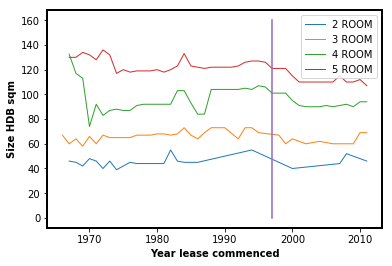

In [21]:
# plot size of HDB flat per year

years = [1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, \
         1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, \
         1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, \
         1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, \
         2006, 2007, 2008, 2009, 2010, 2011,]
def function(x):
    try:
        return np.percentile(train2[train2['lease_commence_date'] == x ]['floor_area_sqm'],50)
    except:
        return np.nan

for i in sorted(train['flat_type'].unique())[1:5]:
    train2=train[train['flat_type']==i]
    temp=map(lambda x : (x,function(x)),years)
    xx=[x[0] for x in temp if x[1] is not np.nan]
    yy=[x[1] for x in temp if x[1] is not np.nan]
    print [x for x in dictt_flattype if dictt_flattype[x] ==i][0], np.mean(yy)
    print [x[0] for x in temp if x[0] >= 2008]
    print [x[1] for x in temp if x[0] >= 2008]
    plt.plot(xx,yy,markersize=2,alpha=0.99,linewidth=1,label=[x for x in dictt_flattype if dictt_flattype[x] ==i][0])
plt.ylabel('Size HDB sqm')
plt.xlabel('Year lease commenced')
plt.plot([1997,1997],[0,160]);plt.legend();plt.savefig('Size_over_time')
plt.show()

In [22]:
# BTO resale data
dictt_bto_year_and_price = {'5 ROOM': 110, '3 ROOM': 65, '4 ROOM': 92, '2 ROOM': 50}
bto = pd.read_csv('price-range-of-hdb-flats-offered.csv2',header=0)  
bto['room_type']=map(lambda x : x[0]+' '+x[2:].upper() , bto['room_type']) #reformat to be simillar to resale data
bto['size']=0
bto['size']=bto['room_type'].map(dictt_bto_year_and_price)
bto['room_type']=bto['room_type'].map(dictt_flattype)
bto['price_sqm']=0
bto['month_mean']=0

# filling in month mean 
for year in [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]:
    median= np.median(train[train.month // 1 == year].month_mean)
    index = bto[bto['financial_year']==year].index
    bto.set_value(index,'month_mean',median)
bto=bto.fillna(0)
bto['price_sqm_unNorm'] = (0.5*bto['min_selling_price']+0.5*bto['max_selling_price'])/\
                    (bto['month_mean']*bto['size']) #yet to normalize by median
bto['price_sqm']=0
# filling in price per sq meter
for x in bto.financial_year.unique(): #normalized to one using median of month as base
    idx = bto[bto['financial_year']==x].index
    temp=bto[bto['financial_year']==x]['price_sqm_unNorm']/np.median(train[train['month']//1==year]['price_sqm_unNorm'])
    temp=bto.set_value(idx,'price_sqm',temp)  

# this following plots makes data by town, and adds BTO data to year 0 #
bto['town']=map(lambda x : x.upper(),bto['town'])
bto['town']=bto['town'].map(dictt_town)


/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667
66.6666666667


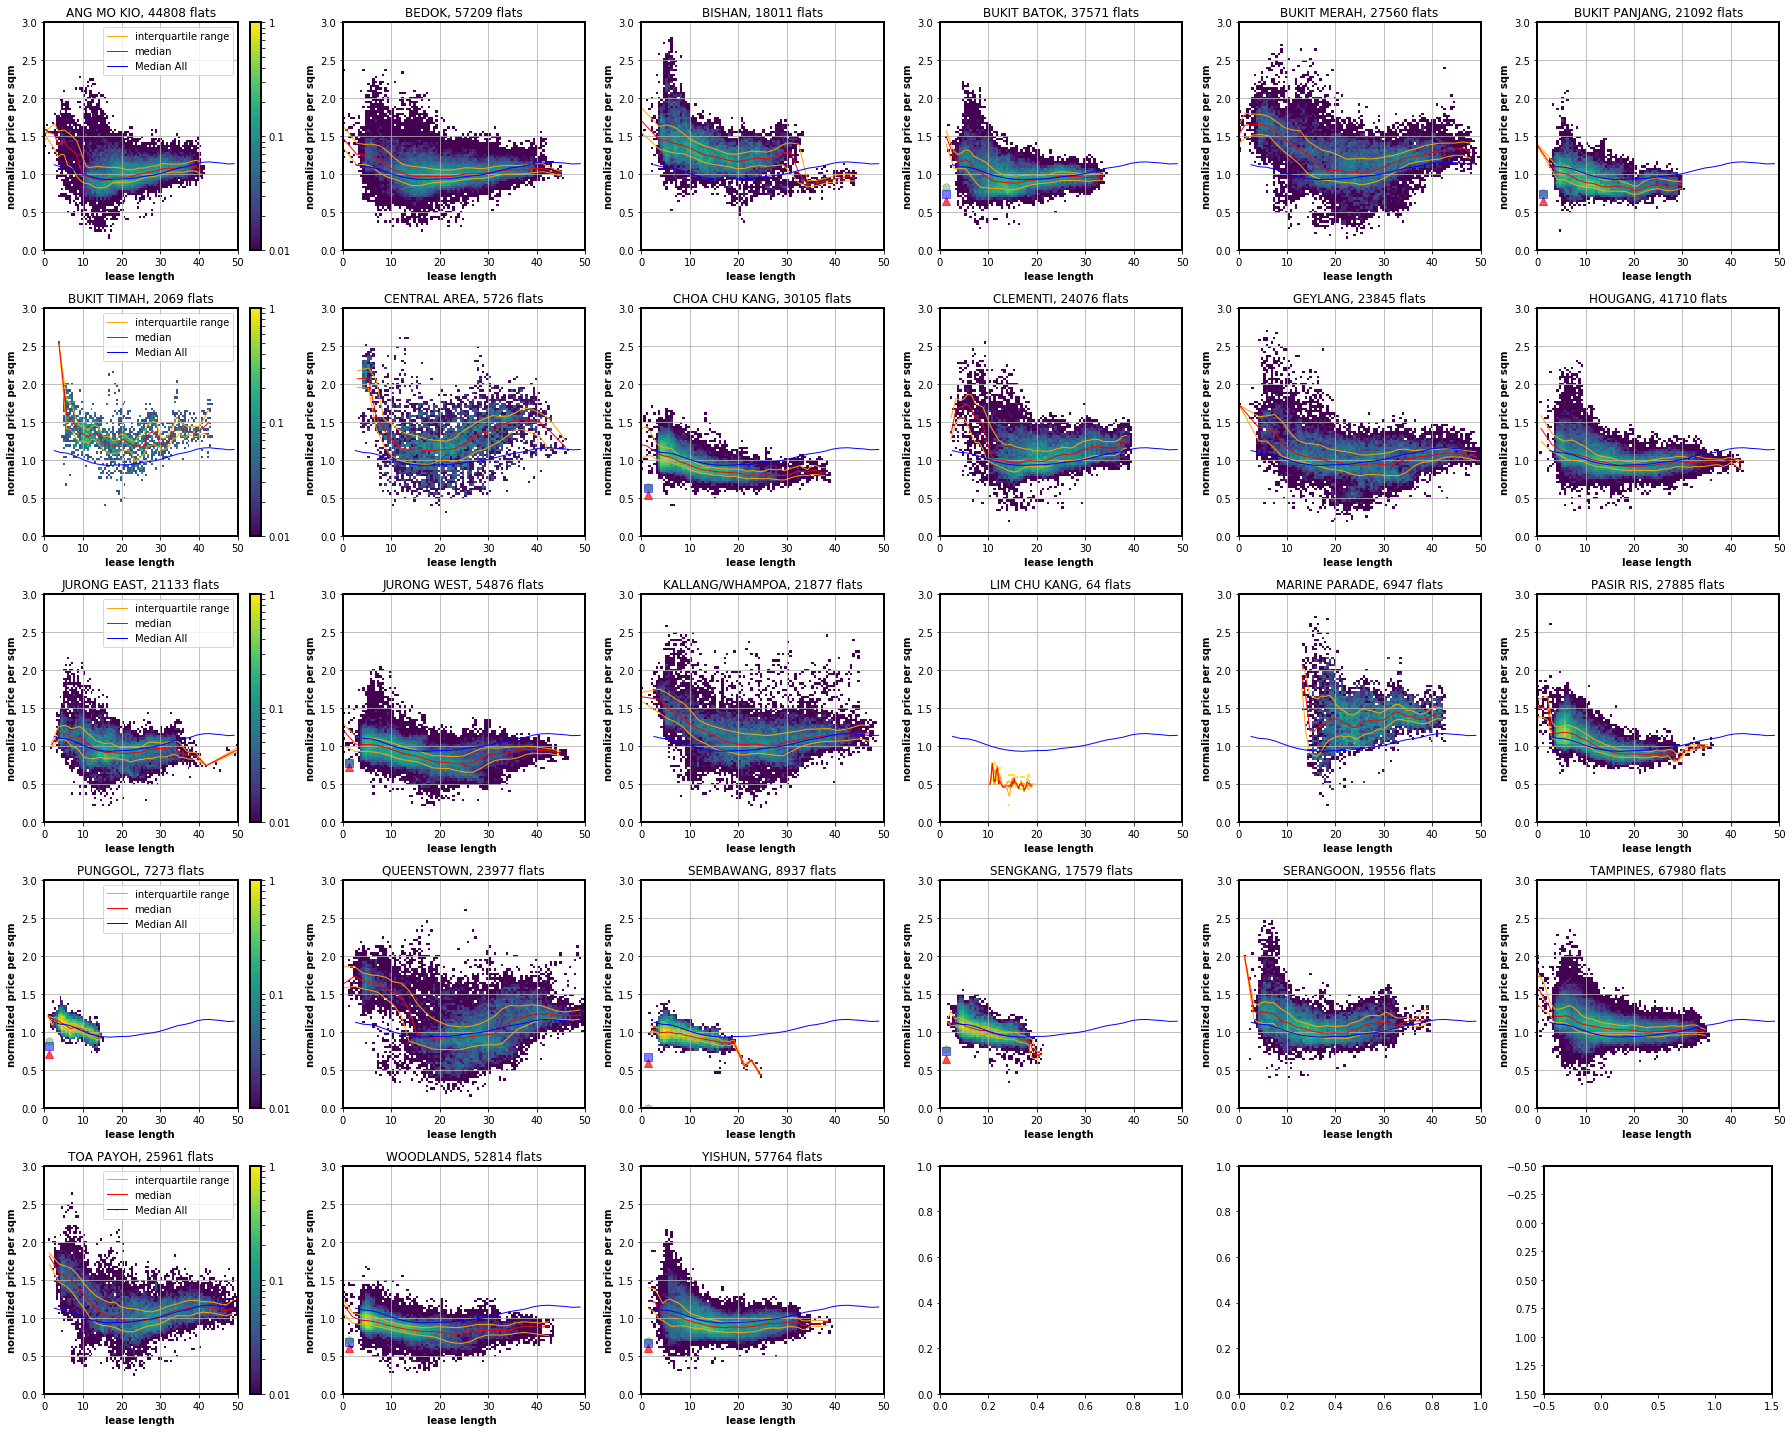

In [23]:
# plots price of flats per town
fig, ax1 = plt.subplots(nrows=5, ncols=6,figsize=(25, 20))
from make_custom_cmap import viridis_data
cdict = viridis_data()
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
for i in range(0,27):
    vmin=.01
    vmax=1
    if i%6==0:
        a=ax1[i//6,i%6].hist2d(train[train['town']==i]['lease_length'],train[train['town']==i]['price_sqm'],100,range=((0,50),(0,3)),\
                               norm=LogNorm(vmin=vmin,vmax=vmax),normed=True,cmap=my_cmap) #using my virgidis cmap and also only values from 0.1 to 100
        aa=ax1[-1,-1].imshow(a[0],cmap=my_cmap,vmin=vmin,vmax=vmax,norm=LogNorm(vmin=vmin,vmax=vmax))
        formatter = LogFormatter(10, labelOnlyBase=False) 
        cb=fig.colorbar(aa,ax=ax1[i//6,i%6],norm=LogNorm(vmin=vmin,vmax=vmax),cmap=my_cmap, format=formatter)
        cb.set_ticks([vmin*x for x in range(1,10)]+[vmin*10*x for x in range(1,10)]+[x for x in range(1,vmax+1,1)])
        cb.set_ticklabels([vmin*x, '', '', '', '','' ,'' , '','' ,vmin*10*x, '', '', '', '','' ,'' , '','' , 1, '', 30,'' , '','','','','',100])
        triple_plot('lease_length','price_sqm',plt=ax1[i//6,i%6],train=train[train['town']==i],legend=True)
        triple_plot2('lease_length','price_sqm',plt=ax1[i//6,i%6],legend=True,train=train[train['lease_length'] > 2.5]) # something funky for lease length 0-2.5
        ax1[i//6,i%6].set_xticks([0,10,20,30,40,50])
        # BTO FLAT
        bto_price=np.median(bto[bto['town']==i][train['price_sqm'] > 0.1][bto['room_type']==3]['price_sqm'])
        ax1[i//6,i%6].plot(1.3,bto_price,'^',color='r',markersize=8,alpha=0.7)
        bto_price=np.median(bto[bto['town']==i][train['price_sqm'] > 0.1][bto['room_type']==4]['price_sqm'])
        ax1[i//6,i%6].plot(1.3,bto_price,'s',color='b',markersize=8,alpha=0.5)
        bto_price=np.median(bto[bto['town']==i][train['price_sqm'] > 0.1][bto['room_type']==5]['price_sqm'])
        ax1[i//6,i%6].plot(1.3,bto_price,'h',color='g',markersize=8,alpha=0.3)
        # END OF BTO FLAT
    else:
        a=ax1[i//6,i%6].hist2d(train[train['town']==i]['lease_length'],train[train['town']==i]['price_sqm'],100,range=((0,50),(0,3)),\
                               norm=LogNorm(vmin=vmin,vmax=vmax),normed=True,cmap=my_cmap)#,norm=LogNorm())
        triple_plot('lease_length','price_sqm',plt=ax1[i//6,i%6],train=train[train['town']==i],legend=False)
        triple_plot2('lease_length','price_sqm',plt=ax1[i//6,i%6],legend=False,train=train[train['lease_length'] > 2.5]) # something funky for lease length 0-2.5
        # BTO FLAT
        bto_price=np.median(bto[bto['town']==i][train['price_sqm'] > 0.1][bto['room_type']==3]['price_sqm'])
        ax1[i//6,i%6].plot(1.3,bto_price,'^',color='r',markersize=8,alpha=0.7)
        bto_price=np.median(bto[bto['town']==i][train['price_sqm'] > 0.1][bto['room_type']==4]['price_sqm'])
        ax1[i//6,i%6].plot(1.3,bto_price,'s',color='b',markersize=8,alpha=0.5)
        bto_price=np.median(bto[bto['town']==i][train['price_sqm'] > 0.1][bto['room_type']==5]['price_sqm'])
        ax1[i//6,i%6].plot(1.3,bto_price,'h',color='g',markersize=8,alpha=0.3)
        # END OF BTO FLAT  
    ax1[i//6,i%6].set_xlabel('lease length ')
    ax1[i//6,i%6].set_title(str([x for x in dictt_town if dictt_town[x]==i][0])+', '+str(sum(train['town']==i))+' flats')
    ax1[i//6,i%6].set_ylabel('normalized price per sqm')
    #print i,i//6,i%6
    ax1[i//6,i%6].grid(True)

    print sum(map(lambda x : sum(x), a[0]))
aa=ax1[-1,-1].imshow([[0,0],[0,0]],norm=LogNorm(vmin=.1,vmax=100))
fig.tight_layout();plt.savefig('town_BTO',dpi=300)
plt.show()

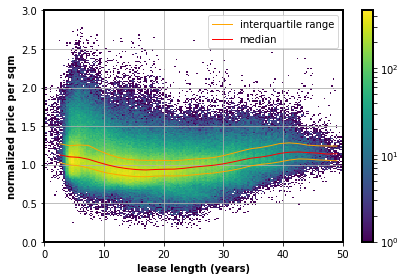

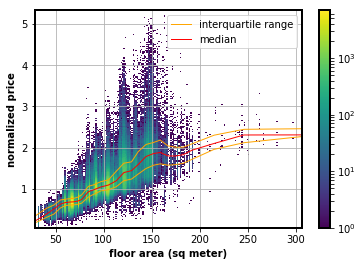

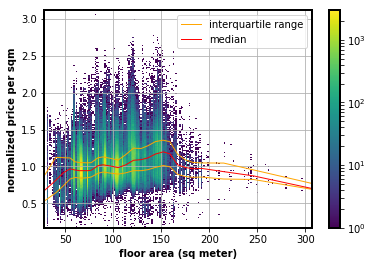

In [24]:
from matplotlib import *
from matplotlib.colors import LogNorm

# Lease length and price
plt.hist2d(train[train['lease_length'] > 0]['lease_length'],train[train['lease_length'] > 0]['price_sqm'],200,norm=LogNorm(),range=((0,50),(0,3)))
plt.colorbar()
plt.xlabel('lease length (years)')
plt.ylabel('normalized price per sqm')
triple_plot('lease_length','price_sqm',train=train[train['lease_length'] > 2.5])  # something funky for lease length 0-2.5, remove it
plt.tight_layout()
plt.grid(True)
plt.savefig('leaseLength_and_price')
plt.show()
plt.clf()
plt.hist2d(train['floor_area_sqm'],train['norresale_price'],200,norm=LogNorm())
triple_plot('floor_area_sqm','norresale_price')
plt.colorbar()
plt.xlabel('floor area (sq meter)')
plt.ylabel('normalized price')
plt.savefig('floor_sq_area')
plt.grid(True)
train[['floor_area_sqm','storey_range','lease_commence_date','month',target]].corr()
plt.show()
plt.clf()
plt.hist2d(train['floor_area_sqm'],train['price_sqm'],200,norm=LogNorm())
triple_plot('floor_area_sqm','price_sqm')
plt.colorbar()
plt.xlabel('floor area (sq meter)')
plt.ylabel('normalized price per sqm')
plt.grid(True)
plt.savefig('floor_sq_area_norm')
train[['floor_area_sqm','storey_range','lease_commence_date','month',target]].corr()
plt.show()
plt.clf()


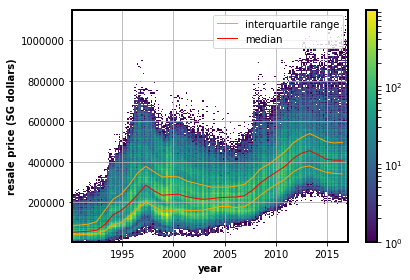

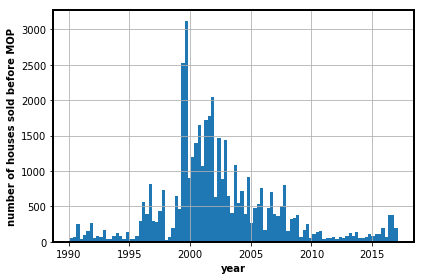

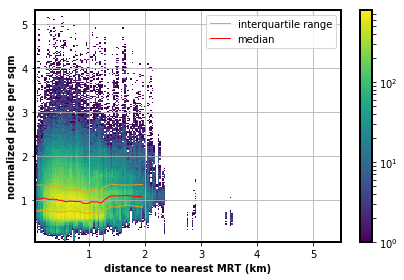

In [25]:
# In[16]:

plt.hist2d(train['month'],train['resale_price'],200,norm=LogNorm())
triple_plot('month','resale_price')
plt.colorbar()
plt.xlabel('year')
plt.ylabel('resale price (SG dollars)')
plt.tight_layout()
plt.grid(True)
plt.savefig('price_over_years')
train[['floor_area_sqm','storey_range','lease_commence_date','month',target]].corr()
plt.show()
plt.clf()

# In[17]:
a=train[train['lease_length']< 5]
plt.hist(a['month'],bins=100)
plt.tight_layout()
plt.xlabel('year')
plt.ylabel('number of houses sold before MOP')
plt.tight_layout()
plt.grid(True)
plt.savefig('b4 five year')
plt.show()
plt.clf()


plt.hist2d(train['dist_nearestMRT'],train['norresale_price'],200,norm=LogNorm())
triple_plot('dist_nearestMRT','norresale_price')
plt.xlabel('distance to nearest MRT (km)')
plt.ylabel('normalized price per sqm')
plt.colorbar()
plt.tight_layout()
plt.grid(True)
plt.savefig('dist_mrt')
train[['dist_nearestMRT',target, 'norresale_price']].corr()
plt.show()
plt.clf()



In [26]:

# some errors in jupyter 
# https://github.com/leexa90/HDB-prices/blob/master/Time_since_mrtBuilt.png

plt.hist2d(train['Time_sinceMRTbuilt'],train['nor'+target],200,norm=LogNorm())
plt.colorbar()
#plt.hist2d(train[train['Time_sinceMRTbuilt'] >0 ]['Time_sinceMRTbuilt'] ,train[train['Time_sinceMRTbuilt'] >0 ]['price_sqm'],200,norm=LogNorm())
plt.xlabel('year since nearest MRT was built')
plt.ylabel('normalized resale price \n(relative to mean of particular month)')
triple_plot('Time_sinceMRTbuilt','norresale_price')
plt.tight_layout()
plt.grid(True)
plt.savefig('Time_since_mrtBuilt')
train[['nor'+target,'Time_sinceMRTbuilt']].corr() #negative correlation, built longer = lower price
plt.show()
plt.clf()

# In[19]:

# https://github.com/leexa90/HDB-prices/blob/master/Time_since_mrtBuilt2.png
plt.hist2d(train['Time_sinceMRTbuilt'],train['price_sqm'],200,norm=LogNorm())
plt.xlabel('year since nearest MRT was built')
plt.ylabel('resale price per sqm \n(relative to mean of particular month)')
triple_plot('Time_sinceMRTbuilt','price_sqm')
plt.tight_layout()
plt.grid(True)
plt.savefig('Time_since_mrtBuilt2')
plt.colorbar()
train[['Time_sinceMRTbuilt','price_sqm']].corr() # negative one percent correlation
plt.show()
plt.clf()

ValueError: cannot convert float NaN to integer

In [ ]:
train['Time_sinceMRTbuilt']

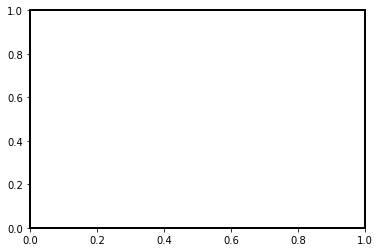

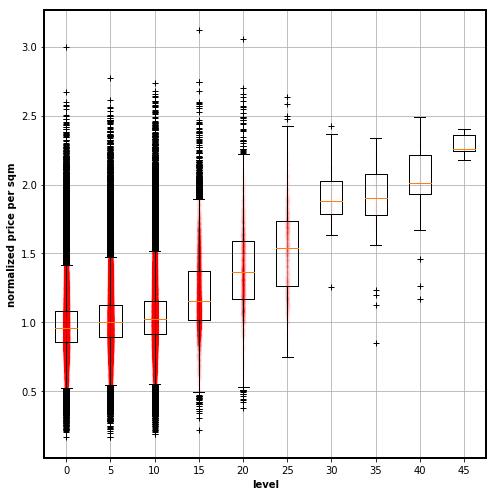

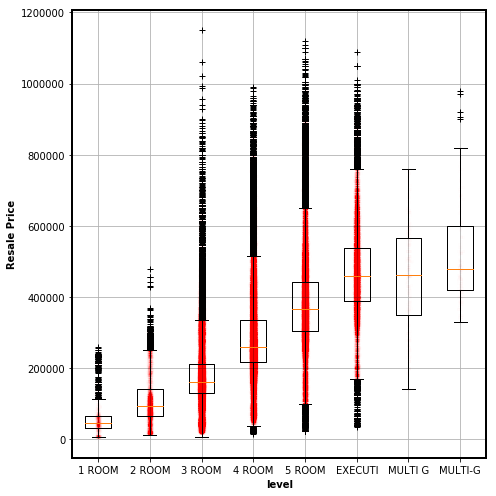

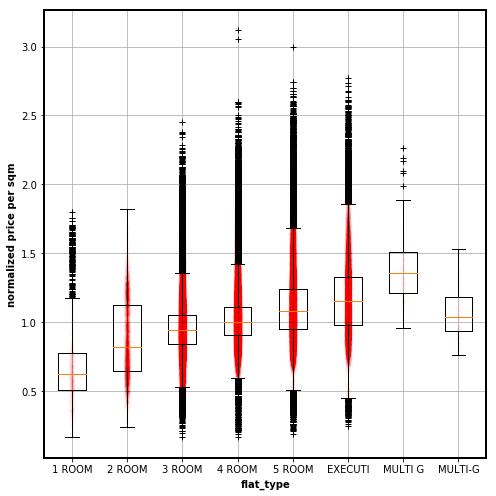

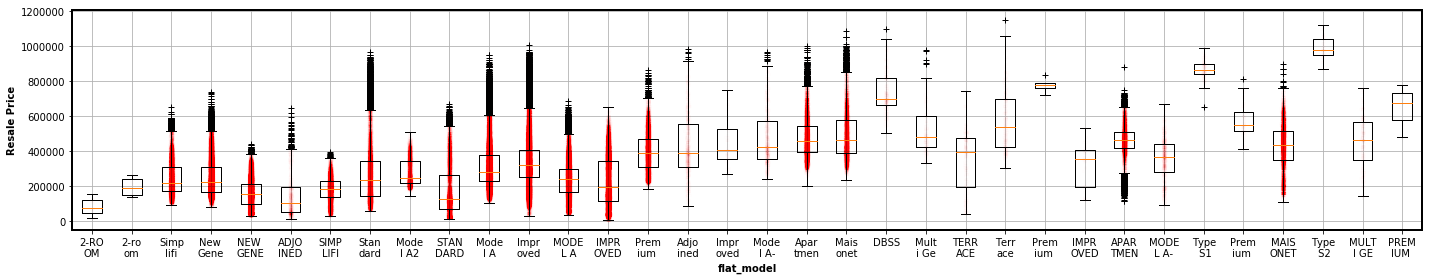

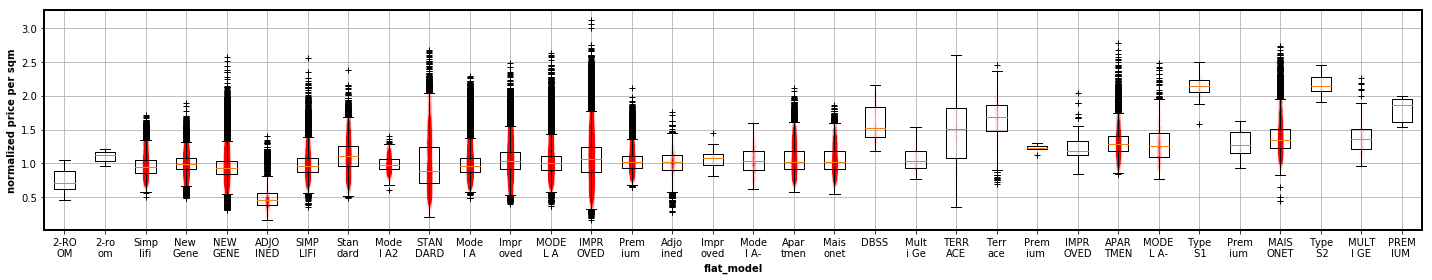

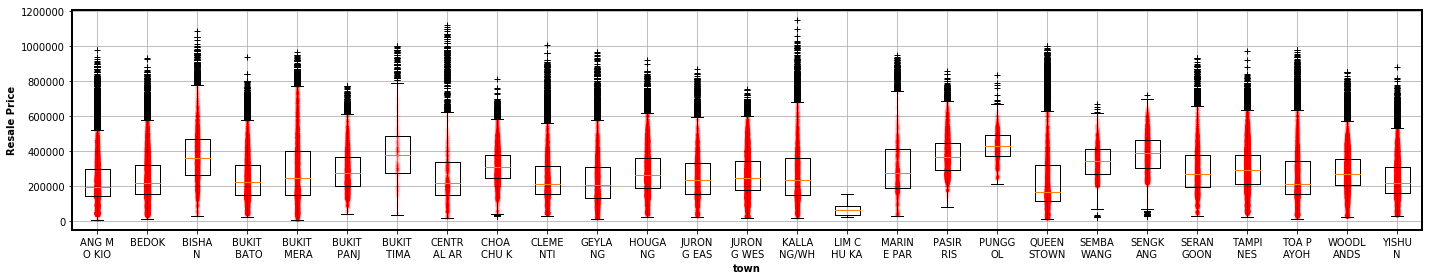

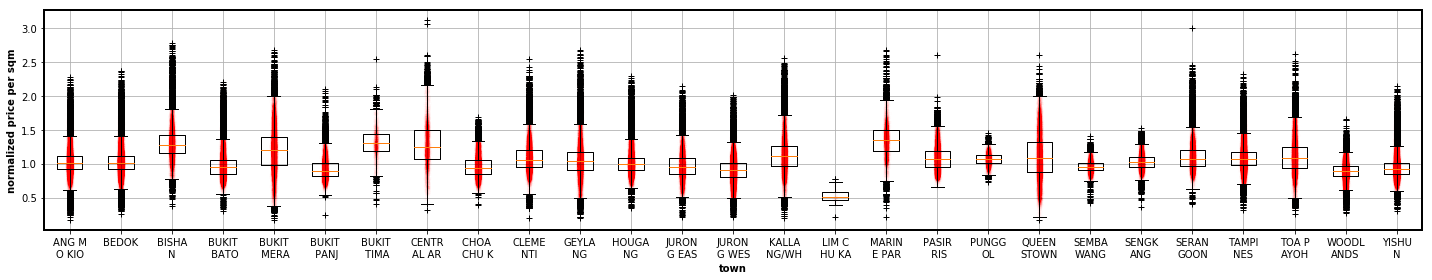

In [27]:
# MANY PLOTS


fig, ax1 = plt.subplots(figsize=(7, 7))
fig.tight_layout(pad=4.0, w_pad=4, h_pad=4)
temp =[]
for i in range(0,int(train['storey_range'].max()),5):
    temp += [train[(train['storey_range'] > i) & (train['storey_range'] < 5+i)]['price_sqm']]
bp=plt.boxplot(temp,notch=0, sym='+', vert=1, whis=1.5)
x_axis=0
for i in range(0,int(train['storey_range'].max()),5):
    x = np.random.normal(x_axis+1, 0.02, size=len(temp[x_axis]))
    plt.plot(x,temp[x_axis] , 'r.', alpha=0.002)
    x_axis += 1
plt.xlabel('level')
plt.ylabel('normalized price per sqm')
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
xtickNames = plt.setp(ax1, xticklabels=range(0,int(train['storey_range'].max()),5))
plt.tight_layout()
plt.grid(True)
plt.savefig('story')


fig, ax1 = plt.subplots(figsize=(7, 7))
fig.tight_layout(pad=4.0, w_pad=4, h_pad=4)
temp =[]
for i in sorted(train['flat_type'].unique()):
    temp += [train[(train['flat_type'] == i)][target]]
bp=plt.boxplot(temp,notch=0, sym='+', vert=1, whis=1.5)
x_axis=0
for i in sorted(train['flat_type'].unique()):
    x = np.random.normal(x_axis+1, 0.02, size=len(temp[x_axis]))
    plt.plot(x,temp[x_axis] , 'r.', alpha=0.002)
    x_axis += 1
plt.xlabel('level')
plt.ylabel('Resale Price')
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
xtickNames = plt.setp(ax1, xticklabels=[x[0:7] for x in sorted(dictt_flattype)])
plt.tight_layout()
plt.grid(True)
plt.savefig('flat_type')


fig, ax1 = plt.subplots(figsize=(7, 7))
fig.tight_layout(pad=4.0, w_pad=4, h_pad=4)
temp =[]
for i in sorted(train['flat_type'].unique()):
    temp += [train[(train['flat_type'] == i)]['price_sqm']]
bp=plt.boxplot(temp,notch=0, sym='+', vert=1, whis=1.5)
x_axis=0
for i in sorted(train['flat_type'].unique()):
    x = np.random.normal(x_axis+1, 0.02, size=len(temp[x_axis]))
    plt.plot(x,temp[x_axis] , 'r.', alpha=0.002)
    x_axis += 1
plt.xlabel('flat_type')
plt.ylabel('normalized price per sqm')
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
xtickNames = plt.setp(ax1, xticklabels=[x[0:7] for x in sorted(dictt_flattype)])
plt.tight_layout()
plt.grid(True)
plt.savefig('flat_type_nor_persqm')


fig, ax1 = plt.subplots(figsize=(20, 4))
fig.tight_layout(pad=4.0, w_pad=4, h_pad=4)
temp =[]
for i in sorted(train.flat_model.unique()):
    temp += [train[(train['flat_model'] == i)][target]]
bp=plt.boxplot(temp,notch=0, sym='+', vert=1, whis=1.5)
x_axis=0
for i in sorted(train.flat_model.unique()):
    x = np.random.normal(x_axis+1, 0.02, size=len(temp[x_axis]))
    plt.plot(x,temp[x_axis] , 'r.', alpha=0.002)
    x_axis += 1
plt.xlabel('flat_model')
plt.ylabel('Resale Price')
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
label_flat_model=[]
for i in range(len(train.flat_model.unique())):
    for j in dictt_flat_model:
        if dictt_flat_model[j] == i:
            label_flat_model += [j[0:4]+'\n'+j[4:8],]
    
xtickNames = plt.setp(ax1, xticklabels=label_flat_model)
plt.tight_layout()
plt.grid(True)
plt.savefig('flat_model')



fig, ax1 = plt.subplots(figsize=(20, 4))
fig.tight_layout(pad=4.0, w_pad=4, h_pad=4)
temp =[]
for i in sorted(train.flat_model.unique()):
    temp += [train[(train['flat_model'] == i)]['price_sqm']]
bp=plt.boxplot(temp,notch=0, sym='+', vert=1, whis=1.5)
x_axis=0
for i in sorted(train.flat_model.unique()):
    x = np.random.normal(x_axis+1, 0.02, size=len(temp[x_axis]))
    plt.plot(x,temp[x_axis] , 'r.', alpha=0.002)
    x_axis += 1
plt.xlabel('flat_model')
plt.ylabel('normalized price per sqm')
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
xtickNames = plt.setp(ax1, xticklabels=label_flat_model)
plt.tight_layout()
plt.grid(True)
plt.savefig('flat_model_nor_persqm')

# town
variable = 'town'

fig, ax1 = plt.subplots(figsize=(20, 4))
fig.tight_layout(pad=4.0, w_pad=4, h_pad=4)
temp =[]
for i in sorted(train[variable].unique()):
    temp += [train[(train[variable] == i)][target]]
bp=plt.boxplot(temp,notch=0, sym='+', vert=1, whis=1.5)
x_axis=0
for i in sorted(train[variable].unique()):
    x = np.random.normal(x_axis+1, 0.02, size=len(temp[x_axis]))
    plt.plot(x,temp[x_axis] , 'r.', alpha=0.002)
    x_axis += 1
plt.xlabel(variable)
plt.ylabel('Resale Price')
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
xtickNames = plt.setp(ax1, xticklabels=[x[0:5]+'\n'+x[5:10] for x in sorted(dictt_town.keys())])
plt.tight_layout()
plt.grid(True)
plt.savefig(variable)


fig, ax1 = plt.subplots(figsize=(20, 4))
fig.tight_layout(pad=4.0, w_pad=4, h_pad=4)
temp =[]
for i in sorted(train[variable].unique()):
    temp += [train[(train[variable] == i)]['price_sqm']]
bp=plt.boxplot(temp,notch=0, sym='+', vert=1, whis=1.5)
x_axis=0
for i in sorted(train[variable].unique()):
    x = np.random.normal(x_axis+1, 0.02, size=len(temp[x_axis]))
    plt.plot(x,temp[x_axis] , 'r.', alpha=0.002)
    x_axis += 1
plt.xlabel(variable)
plt.ylabel('normalized price per sqm')
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
xtickNames = plt.setp(ax1, xticklabels=[x[0:5]+'\n'+x[5:10] for x in sorted(dictt_town.keys())])
plt.tight_layout()
plt.grid(True)
plt.savefig(variable+'nor_persqm')
plt.show()